# Basic Text Classification with Naive Bayes
***
In this mini-project, we will perform text analysis using a subset of movie reviews from the rotten tomatoes database using a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class. 

# Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.8)

# Rotten Tomatoes Dataset

In [3]:
critics = pd.read_csv('./data/critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


## Explore

In [4]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


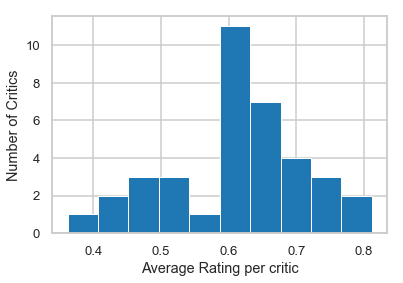

In [5]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

**Observations**  
From the above histogram, the distribution appears right leaning. More critics provide an above average rating, i.e., they rate more movies 'fresh' instead of 'rotten'. One possible explanation a good movie tends to draw more critic review. As a result, the obtained data contains more 'fresh' ratings than a 'rotten' movie. 


# The Vector Space Model and a Search Engine

All the diagrams here are snipped from [*Introduction to Information Retrieval* by Manning et. al.]( http://nlp.stanford.edu/IR-book/) which is a great resource on text processing. For additional information on text mining and natural language processing, see [*Foundations of Statistical Natural Language Processing* by Manning and Schutze](http://nlp.stanford.edu/fsnlp/).

Also check out Python packages [`nltk`](http://www.nltk.org/), [`spaCy`](https://spacy.io/), [`pattern`](http://www.clips.ua.ac.be/pattern), and their associated resources. Also see [`word2vec`](https://en.wikipedia.org/wiki/Word2vec).

Let us define the vector derived from document $d$ by $\bar V(d)$. What does this mean? Each document is treated as a vector containing information about the words contained in it. Each vector has the same length and each entry "slot" in the vector contains some kind of data about the words that appear in the document such as presence/absence (1/0), count (an integer) or some other statistic. Each vector has the same length because each document shared the same vocabulary across the full collection of documents -- this collection is called a *corpus*.

To define the vocabulary, we take a union of all words we have seen in all documents. We then just associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Suppose we have the following corpus:

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree. The grapes seemed ready to burst with juice, and the Fox's mouth watered as he gazed longingly at them.`

Suppose we treat each sentence as a document $d$. The vocabulary (often called the *lexicon*) is the following:

$V = \left\{\right.$ `a, along, and, as, at, beautiful, branches, bunch, burst, day, fox, fox's, from, gazed, grapes, hanging, he, juice, longingly, mouth, of, one, ready, ripe, seemed, spied, the, them, to, trained, tree, vine, watered, with`$\left.\right\}$

Then the document

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree`

may be represented as the following sparse vector of word counts:

$$\bar V(d) = \left( 4,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,2,1,0,1,0,0,1,0,0,1,1,1,0,0 \right)$$

or more succinctly as

`[(0, 4), (1, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (12, 1), (14, 1), (15, 1), (20, 2), (21, 1), (23, 1),`
`(26, 1), (29,1), (30, 1), (31, 1)]`

along with a dictionary

``
{
    0: a, 1: along, 5: beautiful, 6: branches, 7: bunch, 9: day, 10: fox, 12: from, 14: grapes, 15: hanging, 19: mouth, 20: of, 21: one, 23: ripe, 24: seemed, 25: spied, 26: the, 29:trained, 30: tree, 31: vine, 
}
``

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays representing documents and columns representing the features/words in the vocabulary.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](images/terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, `jealous` and `jealousy` after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all depends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](images/vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](images/terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

Then we can use this simple Vector Model as a Search engine.

## In Code

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [7]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(critics)

# Naive Bayes

From Bayes' Theorem, we have that

$$P(c \vert f) = \frac{P(c \cap f)}{P(f)}$$

where $c$ represents a *class* or category, and $f$ represents a feature vector, such as $\bar V(d)$ as above. **We are computing the probability that a document (or whatever we are classifying) belongs to category *c* given the features in the document.** $P(f)$ is really just a normalization constant, so the literature usually writes Bayes' Theorem in context of Naive Bayes as

$$P(c \vert f) \propto P(f \vert c) P(c) $$

$P(c)$ is called the *prior* and is simply the probability of seeing class $c$. But what is $P(f \vert c)$? This is the probability that we see feature set $f$ given that this document is actually in class $c$. This is called the *likelihood* and comes from the data. One of the major assumptions of the Naive Bayes model is that the features are *conditionally independent* given the class. While the presence of a particular discriminative word may uniquely identify the document as being part of class $c$ and thus violate general feature independence, conditional independence means that the presence of that term is independent of all the other words that appear *within that class*. This is a very important distinction. Recall that if two events are independent, then:

$$P(A \cap B) = P(A) \cdot P(B)$$

Thus, conditional independence implies

$$P(f \vert c)  = \prod_i P(f_i | c) $$

where $f_i$ is an individual feature (a word in this example).

To make a classification, we then choose the class $c$ such that $P(c \vert f)$ is maximal.

There is a small caveat when computing these probabilities. For [floating point underflow](http://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html) we change the product into a sum by going into log space. This is called the LogSumExp trick. So:

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$

There is another caveat. What if we see a term that didn't exist in the training data? This means that $P(f_i \vert c) = 0$ for that term, and thus $P(f \vert c)  = \prod_i P(f_i | c) = 0$, which doesn't help us at all. Instead of using zeros, we add a small negligible value called $\alpha$ to each count. This is called Laplace Smoothing.

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the number of times class $c$ was seen and $N_i$ is the number of times feature $i$ was seen globally. $\alpha$ is sometimes called a regularization parameter.

## Multinomial Naive Bayes and Other Likelihood Functions

Since we are modeling word counts, we are using variation of Naive Bayes called Multinomial Naive Bayes. This is because the likelihood function actually takes the form of the multinomial distribution.

$$P(f \vert c) = \frac{\left( \sum_i f_i \right)!}{\prod_i f_i!} \prod_{f_i} P(f_i \vert c)^{f_i} \propto \prod_{i} P(f_i \vert c)$$

where the nasty term out front is absorbed as a normalization constant such that probabilities sum to 1.

There are many other variations of Naive Bayes, all which depend on what type of value $f_i$ takes. If $f_i$ is continuous, we may be able to use *Gaussian Naive Bayes*. First compute the mean and variance for each class $c$. Then the likelihood, $P(f \vert c)$ is given as follows

$$P(f_i = v \vert c) = \frac{1}{\sqrt{2\pi \sigma^2_c}} e^{- \frac{\left( v - \mu_c \right)^2}{2 \sigma^2_c}}$$

**Implementing a Naive Bayes Classifier**

<ol>
<li> split the data set into a training and test set
<li> Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
<li> Train the classifier over the training set and test on the test set
<li> Print the accuracy scores for both the training and the test sets
</ol>


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)
classifier = MultinomialNB()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print('Accuracy Score on Train data: {0:.3f}'.format(classifier.score(X_train, y_train)))
print('Accuracy Score on Test data: {0:.3f}'.format(classifier.score(X_test, y_test)))

Accuracy Score on Train data: 0.921
Accuracy Score on Test data: 0.778


**Observations:**  
The classifier has a good accuracy over the training data but average accuracy for the test data. This is probably due to overfitting. 

## Picking Hyperparameters for Naive Bayes and Text Maintenance

We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

### Tuning `min_df` and `max_df`
First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary. From the documentation:

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

**Constructing the cumulative distribution of document frequencies (df)**  
The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear in 5 or fewer documents.</p>

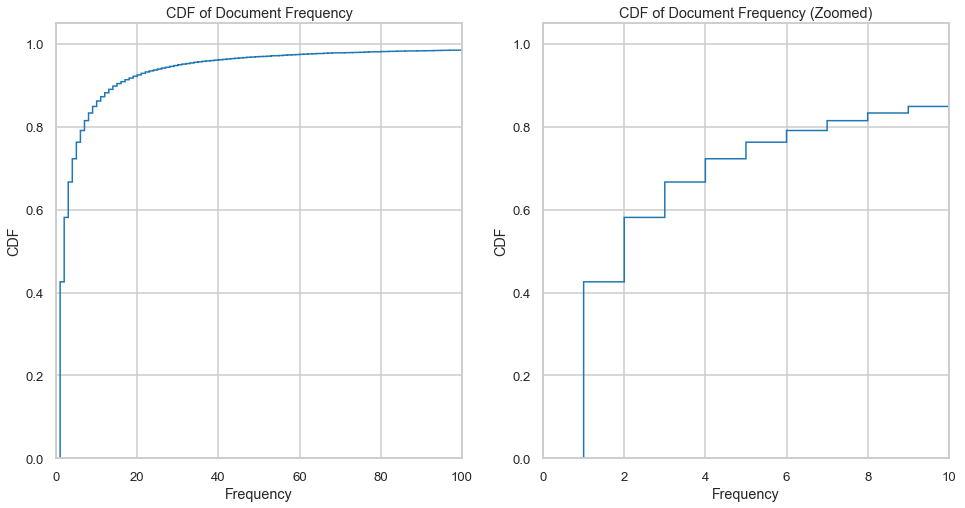

In [9]:
X2, y2 = make_xy(critics)
#freq = X2.sum(axis=0).tolist()[0]
freq = np.array(X2.sum(axis=0))[0]
df2 = pd.DataFrame(freq)
df2 = df2.reset_index()
df2.columns = ['word_index', 'frequency']
f, axes = plt.subplots(1, 2, figsize = (16, 8))
axes[1].hist(df2.frequency, cumulative=True, normed=True, histtype='step', bins=max(df2.frequency))
axes[1].set(xlim=[0, 10], xlabel='Frequency', ylabel='CDF', title='CDF of Document Frequency (Zoomed)')
axes[0].hist(df2.frequency, cumulative=True, normed=True, histtype='step', bins=max(df2.frequency))
axes[0].set(xlim=[0, 100], xlabel='Frequency', ylabel='CDF', title='CDF of Document Frequency')
plt.show()

**Observations**  
* `min_df`: Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. From the above, there seems to be close to 60% of the words are appear in less than or equal to 2 documents. Many misspelt words will occur just once. We should ignore those. Some words specific to the movie might appear once or twice in the review.
* If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. 
* A possible good choice for (min_df, max_df) = (5, 50)

### Tuning $\alpha$ 
The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [10]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [11]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [12]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

**Few notes about log_likelihood function and Hyperparamter $\alpha$**
* The function 'log_likelihood' sums up Prob$(\hat{x}=1|x=1)$ + Prob$(\hat{x}=0|x=0)$ (the likelihood values). For all the movies rated 'fresh', we sum up the probability that the we classified it as 'fresh'. In other words, we give higher weightage if the Probability of it being a 1 (indicating fresh) is higher (similarly for the 'rotten' ratings too). We are optimizing the likelihood probabilities of each detection  
* $\alpha$ is used in $$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$ as a smoothening parameter. It is used to avoid scenarios where the test set has words out of the vocabulary (determined by the training set). If we use a high value of $\alpha$, it would result in incorrect probability calculation and hence a low accuracy in our model.


**Finding the best values of the parameter `alpha`, using the value of `min_df` obtained in the previous section. We use the `cv_score` function above with the `log_likelihood` function for scoring**

In [13]:
# Search over alpha and min_df to find the best set of parameter
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [1, 2, 3, 4, 5]
min_dfs = [1, 2, 3, 4, 5]
max_dfs = [0.2, 0.3, 0.4, 0.5]

best_min_df, best_max_df, best_alpha = None, None, None
maxscore=-np.inf
for min_df in min_dfs:
    for alpha in alphas:
        for max_df in max_dfs:
            vectorizer = CountVectorizer(min_df=min_df, max_df = max_df)       
            Xthis, ythis = make_xy(critics, vectorizer)
            Xtrainthis = Xthis[mask]
            ytrainthis = ythis[mask]
            classifier = MultinomialNB(alpha=alpha)
            score = cv_score(classifier, Xtrainthis, ytrainthis, log_likelihood)
            (best_min_df, best_max_df, best_alpha, maxscore) = (min_df, max_df, alpha, score) if score>maxscore else (best_min_df, best_max_df, best_alpha, maxscore)
        
print("min_df: {0:d}, max_df: {1:.2f}, alpha: {2:d}, score: {3:.2f}".format(best_min_df, best_max_df, best_alpha, maxscore))


min_df: 5, max_df: 0.20, alpha: 2, score: -565.71


### Modelling with the Best Parameters

In [14]:
from sklearn.metrics import confusion_matrix

# Using the best values obtained from the above hyperparameter tuning
best_min_df, best_max_df, best_alpha = 5, 0.2, 2 # Obtained from the above hyperparameter tuning

vectorizer = CountVectorizer(min_df=best_min_df, max_df=best_max_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print('CountVectorizer + Naive Bayes Classifier')
print('------------------------------')
print("Accuracy on training data: {:.2f}".format(training_accuracy))
print("Accuracy on test data:     {:.2f}".format(test_accuracy))
print('\nConfusion Matrix: ')
print(confusion_matrix(ytest, clf.predict(xtest)))

CountVectorizer + Naive Bayes Classifier
------------------------------
Accuracy on training data: 0.90
Accuracy on test data:     0.74

Confusion Matrix: 
[[2488 1741]
 [1073 5590]]


**Note:** Though this classifier has a lower accuracy for both training and test data, it is not an overfit classifier as the earlier model


## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [15]:
words = np.array(vectorizer.get_feature_names())
x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
            touching 0.92
         masterpiece 0.91
              brings 0.91
              decade 0.91
              superb 0.90
              moving 0.90
               witty 0.90
          remarkable 0.89
          delightful 0.89
             delight 0.89
Bad words	     P(fresh | word)
               tired 0.21
             writers 0.20
              dreary 0.20
                dull 0.20
           pointless 0.18
             muddled 0.17
          uninspired 0.17
             problem 0.17
                lame 0.15
       unfortunately 0.11


**Why does this method work? What does the probability for each row in the identity matrix represent?**  
We are effectively selecting the 10 best features for 'fresh' class and the 10 best features for 'rotten' clas. Each row in the identity matrix represents just 1 word. The probability for each row corresponds to the likelihood that each word will be classified as a 'fresh' rated movie, i.e., if a review would have just 1 word, then how likely will that be classified as a 'fresh' by our model. 


The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

### Prediction Errors

We can see mis-predictions as well.

In [16]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print('p={0:.2e}, Review: '.format((prob[y==0])[row]), critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print('p={0:.2f}, Review: '.format((prob[y==1])[row]), critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
p=2.94e-04, Review:  I know that Platoon is being acclaimed for its realism, and I expect to be chastened for being a woman finding fault with a war film. But I've probably seen as much combat as most of the men saying, 'This is how war is.'

p=6.86e-04, Review:  With everything to work with, director Stanley Kubrick has teamed with jumpy Jack Nicholson to destroy all that was so terrifying about Stephen King's bestseller.

p=7.51e-04, Review:  It survives today only as an unusually pure example of a typical 50s art-film strategy: the attempt to make the most modern and most popular of art forms acceptable to the intelligentsia by forcing it into an arcane, antique mold.

p=7.99e-04, Review:  Walken is one of the few undeniably charismatic male villains of recent years; he can generate a snakelike charm that makes his worst characters the most memorable, and here he operates on pure style.

p=1.32e-03, Review:  The thought that he

### Predicting the Freshness for a New Review
<ul>
<li> Using the best trained classifier, let us predict the freshness of the a new review: 'This movie is not remarkable, touching, or superb in any way'
</ul>


In [17]:
sentence = ['This movie is not remarkable, touching or superb in any way']
prob_new_review = clf.predict_proba(vectorizer.transform(sentence))
print('Freshness probability: {:.4f}'.format(prob_new_review[0, 1]))

Freshness probability: 0.9952


**Observation**  
We can see that our classifier predicts this review as a very strong 'fresh' which clearly is not the case. This classifier classifies based on the bag of words. Besides the word 'not' (which probably doesnt play any role in classification since it can be used in positive or negative reviews), the sentence has several positive words - 'remarkable', 'touching' and 'superb'. Hence our classifier sees these 3 words and strongly predicts it as a 'fresh' or a 'positive' review

# TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks: 

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$

where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$

In [18]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix

**Hyperparameter Tuning**

In [19]:
#Hyperparameter Tuning for TD-IDF + Naive Bayes
alphas = [1, 2, 3, 4, 5]
min_dfs = [1, 2, 3, 4, 5]
max_dfs = [0.2, 0.3, 0.4, 0.5]

best_min_df, best_max_df, best_alpha = None, None, None
maxscore=-np.inf
for min_df in min_dfs:
    for alpha in alphas:
        for max_df in max_dfs:
            tfidfvectorizer = TfidfVectorizer(min_df=min_df, max_df = max_df, stop_words='english') 
            Xthis, ythis = make_xy(critics, tfidfvectorizer)
            Xtrainthis = Xthis[mask]
            ytrainthis = ythis[mask]
            classifier = MultinomialNB(alpha=alpha)
            score = cv_score(classifier, Xtrainthis, ytrainthis, log_likelihood)
            (best_min_df, best_max_df, best_alpha, maxscore) = (min_df, max_df, alpha, score) if score>maxscore else (best_min_df, best_max_df, best_alpha, maxscore)
        
print("min_df: {0:d}, max_df: {1:.2f}, alpha: {2:d}, score: {3:.2f}".format(best_min_df, best_max_df, best_alpha, maxscore))

min_df: 5, max_df: 0.20, alpha: 1, score: -543.22


**Model Building**

In [20]:
best_min_df, best_max_df, best_alpha = 5, 0.2, 1 # Obtained from the above hyperparameter tuning

tfidfvectorizer = TfidfVectorizer(min_df=best_min_df, max_df = best_max_df, stop_words='english') 
X, y = make_xy(critics, tfidfvectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)


print('TD-IDF Vectorizer + Naive Bayes Classifier')
print('--------------------------------------------')
print("Accuracy on training data: {:.2f}".format(training_accuracy))
print("Accuracy on test data:     {:.2f}".format(test_accuracy))
print('\nConfusion Matrix: ')
print(confusion_matrix(ytest, clf.predict(xtest)))

TD-IDF Vectorizer + Naive Bayes Classifier
--------------------------------------------
Accuracy on training data: 0.87
Accuracy on test data:     0.71

Confusion Matrix: 
[[1587 2642]
 [ 476 6187]]


# N-gram Naive Bayes Model

Here, we build a Vectorizer model with features to include 2-word and 3-words. This is useful because "not good" and "so good" mean very different things. 

**Hyperparameter Tuning**

In [21]:
#Hyperparameter Tuning for N-Gram Model
alphas = [1, 5, 10, 20]
min_dfs = [1, 10, 20, 50]
max_dfs = [0.01, 0.05, 0.1]

ngram_list = [2, 3]
best_min_df, best_max_df, best_alpha = None, None, None
maxscore=-np.inf
for ngram in ngram_list:
    for min_df in min_dfs:
        for alpha in alphas:
            for max_df in max_dfs:
                vectorizer = CountVectorizer(ngram_range=(1, ngram), min_df=min_df, max_df = max_df) 
                Xthis, ythis = make_xy(critics, vectorizer)
                Xtrainthis = Xthis[mask]
                ytrainthis = ythis[mask]
                classifier = MultinomialNB(alpha=alpha)
                score = cv_score(classifier, Xtrainthis, ytrainthis, log_likelihood)
                (best_min_df, best_max_df, best_alpha, maxscore) = (min_df, max_df, alpha, score) if score>maxscore else (best_min_df, best_max_df, best_alpha, maxscore)

    print("{0:d}-gram: min_df: {1:d}, max_df: {2:.2f}, alpha: {3:d}, score: {4:.2f}".format(ngram, best_min_df, best_max_df, best_alpha, maxscore))

2-gram: min_df: 10, max_df: 0.01, alpha: 10, score: -543.51
3-gram: min_df: 10, max_df: 0.01, alpha: 10, score: -543.51


**Model Building**

In [22]:
## n-gram model 
ngram_list = [2, 3]
best_min_df, best_max_df, best_alpha = [10, 10], [0.01, 0.01], [10, 10] # Obtained from the above hyperparameter tuning

for ngram, min_df, max_df, alpha in zip(ngram_list, best_min_df, best_max_df, best_alpha):
    vec_ngram = CountVectorizer(ngram_range=(1, ngram), min_df=min_df, max_df = max_df)
    X, y = make_xy(critics, vec_ngram)

    xtrain=X[mask]
    ytrain=y[mask]
    xtest=X[~mask]
    ytest=y[~mask]

    clf = MultinomialNB(alpha=alpha).fit(xtrain, ytrain)

    training_accuracy = clf.score(xtrain, ytrain)
    test_accuracy = clf.score(xtest, ytest)
    
    print('{0:d}-gram CountVectorizer + Naive Bayes Classifier'.format(ngram))
    print('-----------------------------------------------------')
    print("{0:d}-gram Classifier: Accuracy on training data: {1:.2f}".format(ngram, training_accuracy))
    print("{0:d}-gram Classifier: Accuracy on test data:     {1:.2f}".format(ngram, test_accuracy))
    
    sentence = ['This movie is not remarkable, touching or superb in any way']
    prob_new_review = clf.predict_proba(vec_ngram.transform(sentence))
    print('\n{0:d}-gram Freshness probability of the new Review: {1:.4f}'.format(ngram, prob_new_review[0, 1]))

    # Top feature for 2-gram classifier
    words = np.array(vec_ngram.get_feature_names())
    x = np.eye(xtest.shape[1])
    probs = clf.predict_log_proba(x)[:, 0]
    ind = np.argsort(probs)

    good_words = words[ind[:5]]
    bad_words = words[ind[-5:]]

    good_prob = probs[ind[:5]]
    bad_prob = probs[ind[-5:]]

    print("\n{}-gram Good words\t     P(fresh | word)".format(ngram))
    for w, p in zip(good_words, good_prob):
        print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

    print("{}-gram Bad words\t     P(fresh | word)".format(ngram))
    for w, p in zip(bad_words, bad_prob):
        print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    print("\n\n")

2-gram CountVectorizer + Naive Bayes Classifier
-----------------------------------------------------
2-gram Classifier: Accuracy on training data: 0.85
2-gram Classifier: Accuracy on test data:     0.71

2-gram Freshness probability of the new Review: 0.9351

2-gram Good words	     P(fresh | word)
              brings 0.81
         masterpiece 0.81
           effective 0.80
               gives 0.80
           enjoyable 0.80
2-gram Bad words	     P(fresh | word)
               fails 0.38
               feels 0.38
                dull 0.38
             problem 0.37
       unfortunately 0.33



3-gram CountVectorizer + Naive Bayes Classifier
-----------------------------------------------------
3-gram Classifier: Accuracy on training data: 0.85
3-gram Classifier: Accuracy on test data:     0.71

3-gram Freshness probability of the new Review: 0.9136

3-gram Good words	     P(fresh | word)
         masterpiece 0.81
              brings 0.81
               gives 0.80
           effective 

**Observations**  
* 2-gram and 3-gram classifiers seems to have poorer accuracy compared to one-gram. Most of the top features are in fact single words. As n increases, the model does not scale well since the feature set becomes more sparse.
* It doesnt seem to do a better job in predicting the freshness of the new review, either. 

# Random Forest Classifer

Here we use a different model (instead of Naive Bayes). Random Forest Classifier is a tree-based classifier and would allow for interactions between words. 

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [42]:
#the grid of parameters to search over
min_dfs = [5]
max_dfs = [0.2]
n_estimator, max_feature = 500, 'sqrt'

vectorizer = CountVectorizer(min_df=min_df, max_df = max_df)       
Xthis, ythis = make_xy(critics, vectorizer)
Xtrainthis = Xthis[mask]
ytrainthis = ythis[mask]

#max_depths = [40, 50, 60]
#best_max_depths = None
#maxscore=-np.inf
#for max_depth in max_depths:
#    classifier = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimator, max_features=max_feature)
#    score = cv_score(classifier, Xtrainthis, ytrainthis, log_likelihood)
#    (best_max_depths, maxscore) = (max_depth, score) if score>maxscore else (best_max_depths, maxscore)
        
#max_depths = 60
#min_samples_leafs = [1, 5, 10]
#best_min_samples_leaf = None
#maxscore=-np.inf
#for min_samples_leaf in min_samples_leafs:
#    classifier = RandomForestClassifier(min_samples_leaf=min_samples_leaf, max_depth=max_depth, n_estimators=n_estimator, max_features=max_feature)
#    score = cv_score(classifier, Xtrainthis, ytrainthis, log_likelihood)
#    (best_min_samples_leaf, maxscore) = (min_samples_leaf, score) if score>maxscore else (best_min_samples_leaf, maxscore)
    
#print("max_depth: {0:d}, min_samples_leaf: {1:d}, score: {2:.2f}".format(max_depths, best_min_samples_leaf, maxscore))

In [44]:

# Using the best values obtained from the above hyperparameter tuning
best_min_df, best_max_df, best_n_estimator = 5, 0.2, 500 # Obtained from the above hyperparameter tuning
best_max_depth, best_min_samples_leaf = 60, 1

vectorizer = CountVectorizer(min_df=best_min_df, max_df=best_max_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = RandomForestClassifier(n_estimators=n_estimator, max_features='sqrt', max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf).fit(xtrain, ytrain)

training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print('CountVectorizer + Random Forest Classifier')
print('--------------------------------------------')
print("Accuracy on training data: {:.2f}".format(training_accuracy))
print("Accuracy on test data:     {:.2f}".format(test_accuracy))

sentence = ['This movie is not remarkable, touching or superb in any way']
prob_new_review = clf.predict_proba(vectorizer.transform(sentence))
print('\nFreshness probability of the new Review: {0:.4f}'.format(prob_new_review[0, 1]))
    
print('\nConfusion Matrix: ')
print(confusion_matrix(ytest, clf.predict(xtest)))

CountVectorizer + Random Forest Classifier
--------------------------------------------
Accuracy on training data: 0.88
Accuracy on test data:     0.67

Freshness probability of the new Review: 0.6036

Confusion Matrix: 
[[1066 3163]
 [ 442 6221]]


# Other Ideas for Future

<p>
There are several additional things we could try. 
<ol>
<li> Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.
<li> Try adding supplemental features -- information about genre, director, cast, etc.
<li> Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.
</ol>
</p>

